# Setting things up

In [1]:
# Import basic packages
import numpy as np
import pandas as pd

# Stats packages
from scipy import stats
from statsmodels.sandbox.distributions import multivariate

# Plotting packages
import plotly.express as px
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# Import packages for analysis
from copulae import StudentCopula
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors


# Get Data
data_dict = np.load("sample_data/fgs.npy" , allow_pickle = True).item()

In [2]:
# Get a df of returns
ret_df = pd.DataFrame()
for product, df in data_dict.items():

    df.sort_index(ascending = True, inplace = True)
    df[product] = df["close"].pct_change()
    df.dropna(axis = 0 , inplace = True)
    ret_df = pd.concat([ret_df, df[[product]]] , axis = 1)

# Deal with NA
ret_df.fillna(method='ffill' , inplace = True)
ret_df.dropna(axis = 0 , inplace = True)

display(ret_df.head())

,F,G,S
date,,,
2012-01-04,-0.014730,0.005067,0.001569
2012-01-05,0.006770,0.006828,0.002662
2012-01-06,-0.014570,-0.003676,-0.002577
2012-01-09,0.021325,-0.004453,0.002427
2012-01-10,0.022550,0.013674,0.008671


In [3]:
# Standardizing or else copula is hard to fit
ret_arr = ret_df.values 
mean_arr = ret_arr.mean(axis = 0)
std_arr = ret_arr.std(axis = 0)
ret_arr_normed = (ret_arr - mean_arr) / std_arr


# Fitting the Copula

In [4]:
# Fit Copula
nobs , ndim = ret_arr_normed.shape
degrees_of_freedom = 5.5 # does not matter, placeholder
t_cop = StudentCopula(dim=ndim, df=degrees_of_freedom)
t_cop.fit(ret_arr_normed)


In [5]:
# See Results
summary = t_cop.summary()
t_cop_df , t_cop_corr = summary.params["Degree of Freedom"] , summary.params["Correlation Matrix"]
display(t_cop_df)
display(t_cop_corr)

4.961824246423177

array([[1.        , 0.39268035, 0.6704833 ],
       [0.39268035, 1.        , 0.36288667],
       [0.6704833 , 0.36288667, 1.        ]])

# Simulating the Copula

## But first , we need to create a class to infer the marginals
For this we use tensorflow probability

In [9]:
class InferStudent():
    def __init__(self, obs_normed):
        self.obs_normed = obs_normed
        
    def initialize_chains(self, mu = None, sigma = None, dof = None, no_of_chains = 2):
        
        if mu is None:
            mu = np.mean(self.obs_normed)
        if sigma is None:
            sigma = np.std(self.obs_normed)
        if dof is None:
            dof = 30
        
        mu = np.repeat(mu , no_of_chains).reshape(-1,1)
        sigma = np.repeat(sigma , no_of_chains).reshape(-1,1)
        dof = np.repeat(dof , no_of_chains).reshape(-1,1)
        
        self.initial_chain_state = [
            tf.cast(mu , name='init_mu', dtype=tf.float32),
            tf.cast(sigma, name='init_sigma', dtype=tf.float32),
            tf.cast(dof, name='init_df', dtype=tf.float32)
        ]

    def run_mcmc(self,n_sim = 1000):
        
        def joint_log_prob(observations_, mu_ , sigma_ , dof_):    

            rv_mu = tfd.Uniform(low= -1., high = 1., name='mu')
            rv_sigma = tfd.HalfNormal(scale = 5., name='sigma')
            rv_dof = tfd.Exponential(rate = 1/30. , name = "df")
            rv_ret = tfd.StudentT(dof_,loc = mu_, scale = sigma_)

            jlp =  rv_mu.log_prob(mu_) + rv_sigma.log_prob(sigma_) + rv_dof.log_prob(dof_) + \
                    tf.reduce_sum(rv_ret.log_prob(observations_))
            return jlp


        unnormalized_posterior_log_prob = lambda *args: joint_log_prob(self.obs_normed, *args)

        ### Set up Transition Kernel
        transition_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                          target_log_prob_fn = unnormalized_posterior_log_prob,
                          step_size = tf.constant(0.5, dtype=tf.float32),
                          num_leapfrog_steps = 2)

        ### Create Tensor Graph and Run MCMC Chain
        @tf.function
        def run_chain(initial_state , num_results = n_sim , num_burnin_steps = 500):

            # Create Adaptive Kernel to adjust step size
            adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
                                    transition_kernel,
                                    num_adaptation_steps = int(0.8 * num_burnin_steps))
            # Run MCMC
            return tfp.mcmc.sample_chain(
                    num_results = num_results,
                    num_burnin_steps = num_burnin_steps,
                    current_state = initial_state,
                    kernel = adaptive_kernel,
                    trace_fn=lambda cs, kr: kr)

        samples_uni, kernel_results_uni = run_chain(initial_state = self.initial_chain_state)
        
        return samples_uni

In [10]:
marginal_params = np.zeros([ret_arr_normed.shape[1] , 3])
marginal_params[:] = np.nan

for i in range(ret_arr_normed.shape[1]):
    student_inference = InferStudent(ret_arr_normed[:,i])
    student_inference.initialize_chains()
    samples = student_inference.run_mcmc(10000)
    
    for j in range(len(samples)):
        r_hat = tfp.mcmc.potential_scale_reduction(samples[j])
        marginal_params[i,j] = stats.mode(samples[j].numpy().flatten()).mode[0]
        print(i , j , r_hat)
#     marginal_params[i,0] = stats.mode(samples[0].numpy()).mode[0]
#     marginal_params[i,1] = stats.mode(samples[1].numpy()).mode[0]
#     marginal_params[i,2] = stats.mode(samples[2].numpy()).mode[0]

0 0 tf.Tensor([1.0007122], shape=(1,), dtype=float32)
0 1 tf.Tensor([1.0017941], shape=(1,), dtype=float32)
0 2 tf.Tensor([3.5485034], shape=(1,), dtype=float32)
1 0 tf.Tensor([1.0000668], shape=(1,), dtype=float32)
1 1 tf.Tensor([1.0668497], shape=(1,), dtype=float32)
1 2 tf.Tensor([2.6948364], shape=(1,), dtype=float32)
2 0 tf.Tensor([1.0001929], shape=(1,), dtype=float32)
2 1 tf.Tensor([1.1411219], shape=(1,), dtype=float32)
2 2 tf.Tensor([19.391878], shape=(1,), dtype=float32)


In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
temp_ = pd.DataFrame(marginal_params , index = ret_df.columns , columns = ["mu","sigma","dof"])
display(temp_)

,mu,sigma,dof
F,-0.184,0.933,29.392
G,-0.091,0.880,25.121
S,0.003,0.861,20.918


In [12]:
n_sim = 5000
t_rvs = multivariate.multivariate_t_rvs(m = np.zeros(ndim), S = t_cop_corr , df = t_cop_df, n = n_sim)
        
# Simulate T copula
t_dist_uni = stats.t(df = nobs -1 )
t_rvs_uniform = t_dist_uni.cdf(t_rvs)
        

In [13]:
feature_transform = {}
for i in range(marginal_params.shape[0]):
    params = marginal_params[i,:]
    marginal_dist = stats.t( params[2] , loc=params[0], scale= params[1])
    feature_transform[ret_df.columns[i]] = marginal_dist.ppf(t_rvs_uniform[:, i])
feature_transform = pd.DataFrame(feature_transform)
feature_transform = feature_transform * std_arr + mean_arr 

## VS the Real data looks different because t is an elliptical distribution

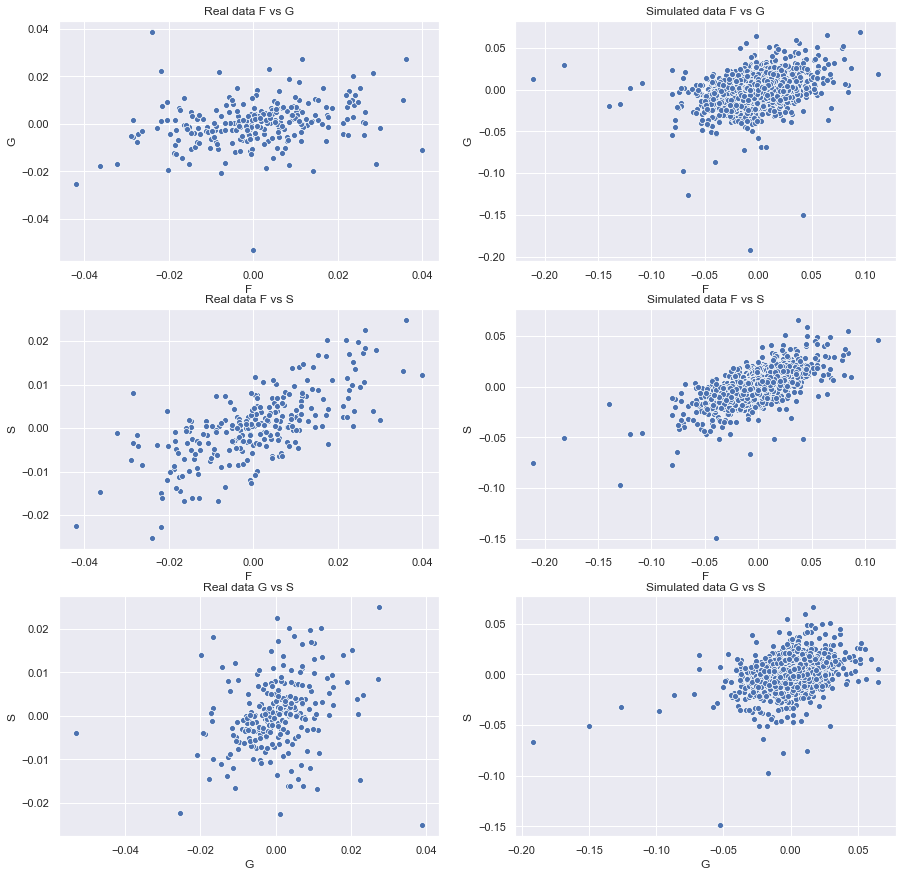

In [14]:
fig, axs = plt.subplots(3,2, figsize=(15, 15))
for index , pair in enumerate([(0,1),(0,2),(1,2)]):
    x_label = ret_df.columns[pair[0]]
    y_label = ret_df.columns[pair[1]]
    sns.scatterplot(x = x_label, y = y_label, data=ret_df, ax = axs[index,0]).set_title( 
                                "Real data {} vs {}".format(x_label, y_label))
    sns.scatterplot(x = x_label, y = y_label, data=feature_transform, ax = axs[index,1]).set_title( 
                                "Simulated data {} vs {}".format(x_label, y_label))